In [303]:
from functions import *


In [304]:
#get pre-scraped text data

with open('rel_articles.txt', 'r') as file:
    data_code = file.read()

exec(data_code)  # Just to verify the content read

#get the data
with open('irrel_articles.txt', 'r') as file:
    data_code = file.read()

exec(data_code)  # Just to verify the content read

rel_location = []
irrel_location = []


#len(relevant_articles)
#len(relevant_articles[0])

there are 16 articles in relevant_articles.
there are 18 articles in irrelevant_articles.


In [305]:
#### preprocess the data with our word_groups
cleaned_rel_articles = []
cleaned_irrel_articles = []

for article in relevant_articles:
    # remove all special characters
    cleaned = article
    cleaned =  re.sub(r'[^-a-zA-Z0-9\s]', '', cleaned)

    # Find all location words
    location_words = find_location(cleaned)
    #print(location_words)
    rel_location.append(location_words)
    # Remove all location words from the text
    for word in location_words:
        cleaned = re.sub(word, '', cleaned)

    #print(find_location(cleaned))
    print("rel============")
    #print("article after removing location", len(article))
    cleaned = text_preprocess(cleaned)
    #print("article after preprocess", len(article))
    cleaned = rep_word_text(cleaned)
    #print("article after rep", len(article))
    cleaned_rel_articles.append(cleaned)

    
for article in irrelevant_articles:
    # remove all special characters
    cleaned = article
    cleaned =  re.sub(r'[^-a-zA-Z0-9\s]', '', cleaned)
    
    # Find all location words
    location_words = find_location(cleaned)
    #print(location_words)
    irrel_location.append(location_words)
    # Remove all location words from the text
    for word in location_words:
        cleaned = re.sub(word, '', cleaned)
    #print(find_location(cleaned))
    print("irrel============")
    
    cleaned = text_preprocess(cleaned)    
    cleaned = rep_word_text(cleaned)
    cleaned_irrel_articles.append(cleaned)
    



rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
rel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============
irrel============


In [306]:
# Training data (target)
labels = []
print(len(cleaned_rel_articles))
print(len(cleaned_irrel_articles))
for i in range(len(cleaned_rel_articles)):
    labels.append('relevant')
for i in range(len(cleaned_irrel_articles)):
    labels.append('irrelevant')

# Training data (independent variable)    
articles = cleaned_rel_articles + cleaned_irrel_articles


16
18


In [307]:
####### Have to have search_results_articles as a pandas data frame

df_articles = pd.DataFrame(articles)

# Save DataFrame to Excel
df_articles.to_excel('tmp_articles.xlsx', index=False)

print("DataFrame has been saved to output.xlsx")


DataFrame has been saved to output.xlsx


### TF-IDF vectorization

In [308]:
#### Vectorizing with the keywords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Initialize TF-IDF vectorizer with preselected keywords
#vectorizer = TfidfVectorizer(vocabulary=keywords)
vectorizer = TfidfVectorizer(stop_words='english')

# Compute TF-IDF scores for articles based on preselected keywords
tfidf_matrix = vectorizer.fit_transform(articles)

# Convert sparse TF-IDF matrix to dense array (for clustering)
tfidf_matrix_dense = tfidf_matrix.toarray()

In [309]:
#### Split the articles into "training set" and "testing set".
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_dense, labels, test_size=0.2, random_state=422)


#### Warning: Because the number of articles are limited, the results highly depends on the training set

### Multinomial Naive Bayesian

In [310]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the classifier
clf = MultinomialNB()

# Train the classifier on the training data
clf.fit(X_train, y_train)


MultinomialNB()

In [311]:
feature_log_prob = clf.feature_log_prob_
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))
top_features = np.argsort(feature_log_prob[0])[::-1][:10]
#feature_names = np.array(feature_names)  # Assuming you have feature names
print("Top features for class 0:")
for feature_idx in top_features:
    print( feature_names[feature_idx], feature_log_prob[0][feature_idx])

2976
Top features for class 0:
vessels -7.29000681004192
fish -7.309186946793564
fishing -7.331599421328959
illegal -7.408758792955732
says -7.4927706431587975
fisheries -7.507877976910703
trade -7.537397563851164
crime -7.555582954240293
whales -7.5830080849558446
blood -7.587845894801934


In [312]:
# Predict on the test data
y_pred = clf.predict(X_test)

In [313]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['relevant', 'irrelevant'], output_dict=True)
#print(report)
#print(type(report))


Accuracy: 0.86


In [314]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics
#class_names = list(report.keys())[:-3]  # Extract class names
class_names = ['relevant', 'irrelevant']
metrics = {'precision': [], 'recall': [], 'f1-score': [], 'support': []}

for cls in class_names:
    metrics['precision'].append(report[cls]['precision'])
    metrics['recall'].append(report[cls]['recall'])
    metrics['f1-score'].append(report[cls]['f1-score'])
    metrics['support'].append(report[cls]['support'])

# Convert to numpy arrays for plotting
precision = np.array(metrics['precision'])
recall = np.array(metrics['recall'])
f1_score = np.array(metrics['f1-score'])
support = np.array(metrics['support'])


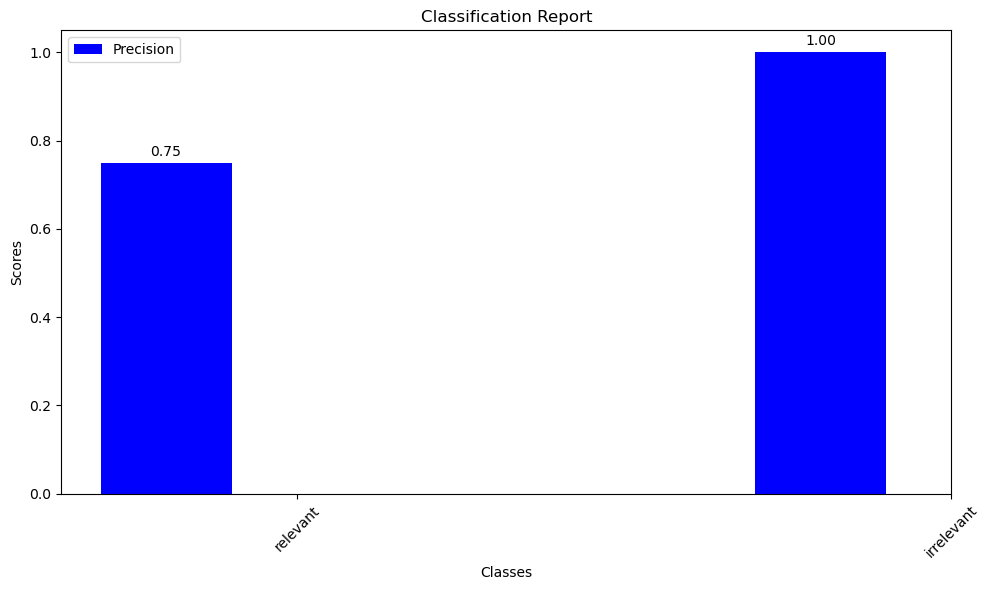

In [315]:
# Plotting the testing result
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(class_names))

bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='b')
#bar2 = ax.bar(index, recall, bar_width, label='Recall', color='g')
#bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1-score', color='r')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report')
ax.set_xticks(index)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
#autolabel(bar2)
#autolabel(bar3)

plt.tight_layout()
plt.show()


### Logistic regression

In [316]:
from sklearn.linear_model import LogisticRegression

# Initialize the classifier
classifier = LogisticRegression()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

LogisticRegression()

In [317]:
# Predict labels for the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.57


[[3 0]
 [3 1]]


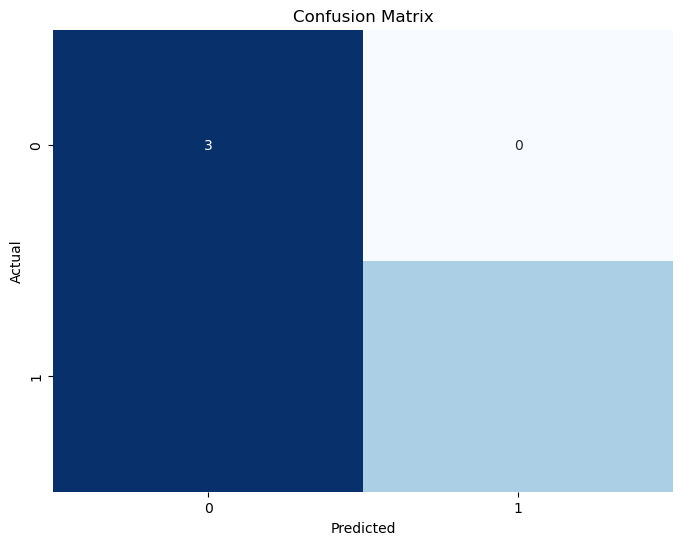

In [318]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [319]:
rel_precision = cm[0][0] / (cm[0][0]+cm[1][0])
irrel_precision = cm[1][1] / (cm[0][1]+cm[1][1])


### Clustering

In [320]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

k =2
# Create KMeans instance
kmeans = KMeans(n_clusters=k)

# Fit KMeans clustering model to TF-IDF data
kmeans.fit(tfidf_matrix)


C:\Users\sumin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [321]:
cluster_labels = kmeans.predict(tfidf_matrix)

# Print cluster labels
print("Cluster labels:", cluster_labels)
#for i, label in enumerate(cluster_labels):
    #print(f"Article {i+1}: Cluster {label}")


Cluster labels: [1 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1]


In [322]:
X = vectorizer.fit_transform(articles)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()


def find_top_words(cluster_label, X, feature_names, top_n=10):
    cluster_indices = np.where(clusters == cluster_label)[0]
    print(cluster_indices)
    cluster_tfidf = np.mean(X[cluster_indices], axis=0).A1  # Average TF-IDF vector
    top_indices = cluster_tfidf.argsort()[-top_n:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    return top_words

top_words = []

for i in range(kmeans.n_clusters):
    top_words.append(find_top_words(i, X, feature_names, top_n=12))
    
for i, words in enumerate(top_words):
    print(f"Cluster {i}: {', '.join(words)}")
    
print("Cluster labels:")
for i, label in enumerate(cluster_labels):
    print(f"Article {i+1}: Cluster {label}")

[ 1  3  4  5  6  7  8  9 10 12 13 14 15 17 18 20 21 22 23 25 26 27 30 33]
[ 0  2 11 16 19 24 28 29 31 32]
Cluster 0: fishing, fish, fisheries, vessels, illegal, catch, said, herring, court, catches, tuna, year
Cluster 1: says, fish, ship, struck, vessel, blood, eye, reported, catches, trawler, man, hitting
Cluster labels:
Article 1: Cluster 1
Article 2: Cluster 1
Article 3: Cluster 1
Article 4: Cluster 0
Article 5: Cluster 0
Article 6: Cluster 0
Article 7: Cluster 1
Article 8: Cluster 0
Article 9: Cluster 0
Article 10: Cluster 0
Article 11: Cluster 0
Article 12: Cluster 1
Article 13: Cluster 0
Article 14: Cluster 0
Article 15: Cluster 0
Article 16: Cluster 0
Article 17: Cluster 1
Article 18: Cluster 0
Article 19: Cluster 0
Article 20: Cluster 0
Article 21: Cluster 0
Article 22: Cluster 0
Article 23: Cluster 0
Article 24: Cluster 0
Article 25: Cluster 1
Article 26: Cluster 0
Article 27: Cluster 0
Article 28: Cluster 0
Article 29: Cluster 1
Article 30: Cluster 1
Article 31: Cluster 0
Art

### Classifying articles from our search

####  Import the articles from the cleaned_for_classification.xslx

In [339]:
import pandas as pd

# read the excel file
excel_data = pd.read_excel('cleaned_for_classification.xlsx')

new_data = excel_data[['Query', 'Engine','Content']]


In [340]:
new_data.head(5)

,Query,Engine,Content
0,Vessel caught misreporting catch amount,Google,sea shepherd global wednesday 05 jun 2024 sea ...
1,Vessel caught misreporting catch amount,Google,move the iuu fight up the food chain proceedi...
2,Vessel caught misreporting catch amount,Google,new rules tighten controls on eu today the env...
3,Vessel caught misreporting catch amount,Google,surprise media being misreporting the source o...
4,Vessel caught misreporting catch amount,Google,sea shepherd global monday 25 mar 2024 in a de...


In [341]:
classified_data = new_data.copy()

data_articles = classified_data['Content'].tolist()
vectorizer_data = TfidfVectorizer(vocabulary = feature_names,stop_words='english')
tfidf_matrix_data = vectorizer_data.fit_transform(data_articles)

tfidf_matrix_dense_data = tfidf_matrix_data.toarray()

y = clf.predict(tfidf_matrix_dense_data)
#y_pred = clf.predict(X_test)

print(len(data_articles))
print(len(y))

classified_data['Relevance'] = y

292
292


### Save the classification data to an excel file

In [344]:
####### Have to have search_results_articles as a pandas data frame

# Save DataFrame to Excel
classified_data.to_excel('classified_data.xlsx', index=False)

print("DataFrame has been saved to output.xlsx")


DataFrame has been saved to output.xlsx


In [366]:
import pandas as pd
classified_data = pd.read_excel('classified_data.xlsx')
classified_data_count = pd.DataFrame(columns = ['Query', 'Engine', 'Count'])
print(len(classified_data_count))
Queries = set(classified_data['Query'].tolist())



for query in Queries:
    Google_rel_count = sum(1 for ind, row in classified_data.iterrows() if (row['Query'] == query) and (row['Engine'] == 'Google') and (row['Relevance'] == 'relevant') )
    Bing_rel_count = sum(1 for ind, row in classified_data.iterrows() if (row['Query'] == query) and (row['Engine'] == 'Bing') and (row['Relevance'] == 'relevant') )
    Yahoo_rel_count = sum(1 for ind, row in classified_data.iterrows() if (row['Query'] == query) and (row['Engine'] == 'Yahoo') and (row['Relevance'] == 'relevant') )
    classified_data_count.loc[len(classified_data_count)] = [query, 'Google', Google_rel_count]
    classified_data_count.loc[len(classified_data_count)] = [query, 'Bing', Bing_rel_count]
    classified_data_count.loc[len(classified_data_count)] = [query, 'Yahoo', Yahoo_rel_count]
    
classified_data_count.head(30)

 

0


,Query,Engine,Count
0,Vessel caught with inaccurate fish size records,Google,1
1,Vessel caught with inaccurate fish size records,Bing,0
2,Vessel caught with inaccurate fish size records,Yahoo,0
3,Vessel caught with unrecorded fish species,Google,0
4,Vessel caught with unrecorded fish species,Bing,0
5,Vessel caught with unrecorded fish species,Yahoo,0
6,Vessel caught bypassing quota system,Google,1
7,Vessel caught bypassing quota system,Bing,0
8,Vessel caught bypassing quota system,Yahoo,0
9,Vessel caught with incorrect catch reports,Google,0


In [370]:
# Declare a classified_data
classified_data = new_data.copy()

count = 0
for rel in y:
    if rel == 'relevant':
        count += 1
print(count)


10


In [362]:
import pandas as pd
from numpy.random import randint

df = pd.DataFrame(columns=['lib', 'qty1', 'qty2'])
for i in range(5):
    df.loc[i] = ['name' + str(i)] + list(randint(10, size=2))
    
df.head(3)

,lib,qty1,qty2
0,name0,3,7
1,name1,9,0
2,name2,5,1
